In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from collections import defaultdict

import sys
if "../" not in sys.path:
  sys.path.append("../")

import gym
import plotting
from lib.envs.blackjack import BlackjackEnv
matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

## Off Policy Monte Carlo Incremental Implementation with Weighted Importance Sampling

In [24]:
def create_behaviour_policy(nA):
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        
        return A
    return policy_fn

In [15]:
def create_target_policy(Q):
    
    def policy_fn(state):
        A = np.zeros_like(Q[state], dtype=float)
        best_action = np.argmax(Q[state])
        A[best_action] = 1.0
        return A
    return policy_fn

In [20]:
def mc_prediction_off_policy_importance_sampling(behaviour_policy, env, num_episodes, discount=1.0, debug=False):
    
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    
    target_policy = create_target_policy(Q)
    
    for i_episode in range(1, num_episodes+1):
        
        if debug:
            if i_episode % 100000 == 0:
                print("\rEpisode {}/{}.".format(i_episode, num_episodes))
                
        state = env.reset()
        episode = []
        while(True):
            probs = behaviour_policy(state)
            action = np.random.choice(len(probs), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
            
        G = 0.0
        W = 1.0
        
        for t in range(len(episode))[::-1]:
            state, action, reward = episode[t]
            G = discount*G + reward
            C[state][action] += W
            Q[state][action] += (W/C[state][action]) * (G - Q[state][action])
            W = W * (target_policy(state)[action]/behaviour_policy(state)[action])
            if W == 0:
                break
    return Q, target_policy

In [17]:
behaviour_policy = create_behaviour_policy(env.action_space.n)
Q, policy = mc_prediction_off_policy_importance_sampling(behaviour_policy, env, num_episodes=500000, debug=True)

Episode 100000/500000.
Episode 200000/500000.
Episode 300000/500000.
Episode 400000/500000.
Episode 500000/500000.


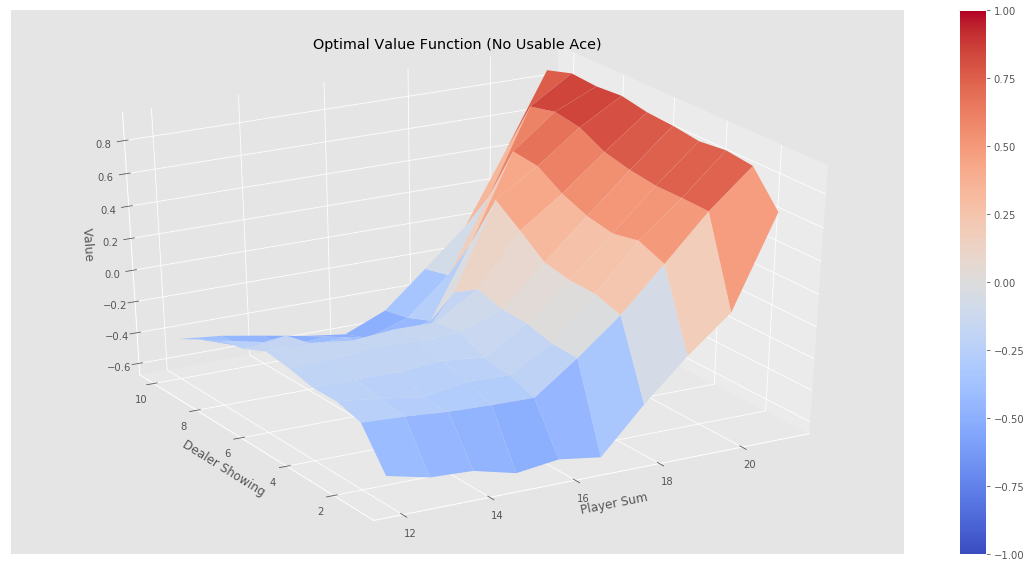

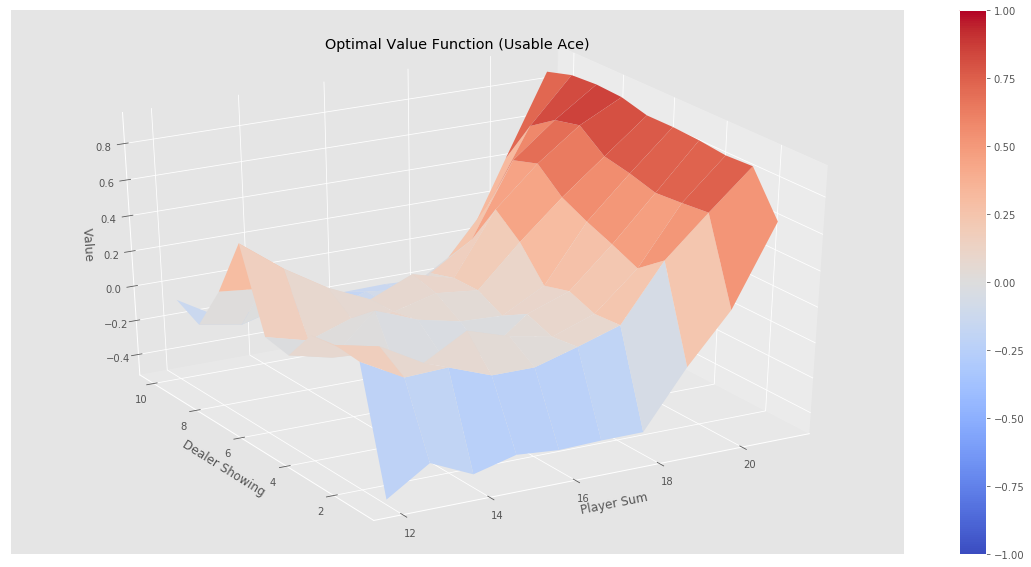

In [18]:
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")